# Load Library

In [1]:
# general imports
import sys
import os
import torch
import torch.nn as nn
import numpy as np
import pandas as pd

In [2]:
torch.__version__

'2.2.1+cu121'

In [3]:
# get the DGD modules (once the current version is public we can switch to the repo)
# git clone https://github.com/Center-for-Health-Data-Science/DeepGenerativeDecoder.git
# for now I added them to this repo, but the imports will stay the same
from src.dgd.latent import RepresentationLayer
from src.dgd.latent import GaussianMixture
from src.dgd.nn import NB_Module

# get the new stuff
from src.utils.helpers import set_seed
from src.model.decoder import Decoder
from src.data.dataset import GeneExpressionDataset
# from src.engine.train import train_dgd

# Set seeds, device, and directory

In [4]:
# set random seeds, device and data directory
seed = 0
set_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

datadir = "./data/"

cpu


# Load Data

In [5]:
tcga_raw = pd.read_table("data/TCGA_mrna_counts_match_transposed.tsv", sep='\t', index_col=[0])
tcga_raw.head()

,ENSG00000186092.4,ENSG00000278566.1,ENSG00000273547.1,ENSG00000187634.11,ENSG00000188976.10,ENSG00000187961.13,ENSG00000187583.10,ENSG00000187642.9,ENSG00000188290.10,ENSG00000187608.8,...,ENSG00000183753.10,ENSG00000188120.14,ENSG00000205944.11,ENSG00000172352.5,ENSG00000183795.8,ENSG00000187191.14,ENSG00000205916.11,ENSG00000185894.8,ENSG00000172288.7,primary_site
TCGA-EW-A6SA-01A-21R-A32P-07,0.0,0.0,1.0,1413.0,9723.0,1310.0,216.0,84.0,972.0,834.0,...,0.0,6.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,Breast
TCGA-E2-A14W-01A-11R-A12D-07,0.0,0.0,0.0,1562.0,6455.0,299.0,489.0,249.0,69.0,538.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Breast
TCGA-EW-A1PD-01A-11R-A144-07,0.0,0.0,1.0,912.0,7050.0,439.0,86.0,23.0,357.0,1281.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Breast
TCGA-55-1594-01A-01R-0946-07,0.0,0.0,0.0,501.0,4238.0,459.0,29.0,13.0,134.0,1300.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Lung
TCGA-49-6742-11A-01R-1858-07,0.0,0.0,0.0,321.0,1791.0,93.0,42.0,18.0,113.0,831.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Lung


In [6]:
# make data split for train and validation sets
out_dim = tcga_raw.shape[1]-1
# shuffle the data
tcga_raw = tcga_raw.sample(frac=1, random_state=seed)

## Data Loader

In [7]:
# make data split for train and validation sets
train_ratio = 0.9
train_data = tcga_raw.iloc[:int(train_ratio*len(tcga_raw)),:]
test_data = tcga_raw.iloc[int(train_ratio*len(tcga_raw)):,:]

# define scaling for NB
# each sample gets a scaling factor
scaling_factors = torch.mean(torch.Tensor(train_data.iloc[:,:-1].to_numpy()), dim=-1).unsqueeze(1)
test_scaling_factors = torch.mean(torch.Tensor(test_data.iloc[:,:-1].to_numpy()), dim=-1).unsqueeze(1)

# make data loaders
train_loader = torch.utils.data.DataLoader(GeneExpressionDataset(train_data),
                                          batch_size=256,
                                          shuffle=True)
test_loader = torch.utils.data.DataLoader(GeneExpressionDataset(test_data),
                                          batch_size=256,
                                          shuffle=True)

In [8]:
print(train_data.shape)
print(test_data.shape)
print(out_dim)

(9613, 19785)
(1069, 19785)
19784


In [9]:
for x, lib, index in train_loader:
    print(x.shape)
    print(lib.shape)
    print(lib)
    print(index.shape)
    print(index)
    break

torch.Size([256, 19784])
torch.Size([256])
tensor([2106.6355, 2816.6323, 2802.3062, 2356.3167, 2293.7065, 1989.7727,
        2619.7019, 2409.9114, 3487.6685, 3406.9453, 3170.9231, 2933.9395,
        2551.9995, 4574.5273, 3074.0405, 2855.6201, 2122.7014, 4199.8223,
        3609.8157, 3833.3523, 1859.8241, 2321.6465, 3705.8311, 1968.2742,
        2268.1155, 1166.4731, 2673.5659, 3579.8430, 3058.7881, 3678.7424,
        4909.6875, 2579.7620, 1055.2968, 3130.0874, 3885.7170, 2954.5498,
        2606.7263, 1358.9561,  699.5521, 3088.5193, 1500.5979, 4109.5400,
        1047.7092, 5697.0381, 2348.4041, 3669.0720, 1429.8934, 3025.8711,
        4294.2397, 3757.9272, 1895.5059, 1190.7009, 2467.8420, 3160.0647,
        1864.1327, 2878.5889, 2868.0308, 2722.6843, 2744.0266, 2711.8381,
        2740.4116, 4446.1030, 2244.2764, 3314.2493, 1288.8728, 2300.0254,
        1883.6438, 3608.5146, 2732.5298, 4166.0410, 4162.9429, 2528.3442,
        4012.2632, 2950.3132, 2925.4192, 2288.1323, 2595.2527, 3370.8

In [11]:
n_tissues = len(tcga_raw["primary_site"].unique())
n_tissues # bit too high with cancer types
# n_tissues = 30

27

In [12]:
# hyperparameters
latent_dim = 20
hidden_dims = [128, 128, 128]
reduction_type = "sum" # output loss reduction

# Decoder Setup

In [13]:
# decoder setup

# set up an output module for the expression data
gex_out_fc = nn.Sequential(
    nn.Linear(hidden_dims[-1], out_dim)
    )
output_gex_layer = NB_Module(gex_out_fc, out_dim, scaling_type="mean")
output_gex_layer.n_features = out_dim

# set up the decoder
decoder = Decoder(latent_dim, hidden_dims, [output_gex_layer]).to(device)

# Specific code (DGD collection and training loop) as examples

Can be changed depending on the model, I assume

## DGD Class

In [14]:
# combine everything in one class (if desired)

class DGD(nn.Module):
    def __init__(self,decoder,n_mix,rep_dim,gmm_spec={}):
        super(DGD, self).__init__()
        self.decoder=decoder
        self.rep_dim = rep_dim      # Dimension of representation

        self.gmm=GaussianMixture(n_mix,rep_dim,**gmm_spec)
        self.train_rep=None
        self.val_rep=None
        self.test_rep=None

    def forward(self,z):
        return self.decoder(z)

    def loss(self,z,y,target,scale,gmm_loss=True,reduction="sum"):
        self.dec_loss = self.decoder.loss(y,target,scale,reduction=reduction)
        if gmm_loss:
            self.gmm_loss = self.gmm(z)
            if reduction=="mean":
                self.gmm_loss = self.gmm_loss.mean()
            elif reduction=="sum":
                self.gmm_loss = self.gmm_loss.sum()
            return self.dec_loss, self.gmm_loss
        else:
            return self.dec_loss, None
    
    def forward_and_loss(self,z,target,scale,gmm_loss=True,reduction="sum"):
        y = self.decoder(z)
        return self.loss(z,y,target,scale,gmm_loss,reduction)
    
    def get_representations(self, type="train"):
        if type=="train":
            return self.train_rep.z.detach().cpu().numpy()
        elif type=="val":
            return self.val_rep.z.detach().cpu().numpy()
        elif type=="test":
            return self.test_rep.z.detach().cpu().numpy()
    
    def get_gmm_means(self):
        return self.gmm.mean.detach().cpu().numpy()
    
    def get_latent_space_values(self, rep_type="train", n_samples=1000):
        # get representations
        if rep_type=="train":
            rep = self.train_rep.z.clone().detach().cpu().numpy()
        elif rep_type=="val":
            rep = self.val_rep.z.clone().detach().cpu().numpy()
        elif rep_type=="test":
            rep = self.test_rep.z.clone().detach().cpu().numpy()
        
        # get gmm means
        gmm_means = self.gmm.mean.clone().detach().cpu().numpy()

        # get some gmm samples
        gmm_samples = self.gmm.sample(n_samples).detach().cpu().numpy()

        return rep, gmm_means, gmm_samples

## Plotting Function

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

def plot_latent_space(rep, means, samples, labels, epoch):
    # get PCA
    pca = PCA(n_components=2)
    pca.fit(rep)
    rep_pca = pca.transform(rep)
    means_pca = pca.transform(means)
    samples_pca = pca.transform(samples)
    df = pd.DataFrame(rep_pca, columns=["PC1","PC2"])
    df["type"] = "rep"
    df["label"] = labels
    df_temp = pd.DataFrame(samples_pca, columns=["PC1","PC2"])
    df_temp["type"] = "samples"
    df = pd.concat([df,df_temp])
    df_temp = pd.DataFrame(means_pca, columns=["PC1","PC2"])
    df_temp["type"] = "means"
    df = pd.concat([df,df_temp])

    # make a figure with 2 subplots
    # set a small text size for figures
    plt.rcParams.update({'font.size': 6})
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    # add spacing between subplots
    plt.subplots_adjust(wspace=0.4)

    # first plot: representations, means and samples
    sns.scatterplot(data=df, x="PC1", y="PC2", hue="type", size="type", sizes=[1,1,10], alpha=0.8, ax=ax[0], palette=["steelblue","orange","black"])
    ax[0].set_title("E"+str(epoch)+": Latent space (by type)")
    ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    sns.scatterplot(data=df[df["type"] == "rep"], x="PC1", y="PC2", hue="label", s=1, alpha=0.8, ax=ax[1])
    ax[1].set_title("E"+str(epoch)+": Latent space (by label)")
    ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2, markerscale=3)

    plt.show()

## Training Function

In [16]:
# write a minimal training function

def train_dgd(dgd, train_loader, validation_loader, device, learning_rates={'dec':0.001,'rep':0.01,'gmm':0.01},weight_decay=0.,nepochs=100,pr=1,plot=10,reduction_type="sum"):
    if reduction_type == "sum":
        tlen=len(train_loader.dataset)*dgd.decoder.n_out_features
        tlen_gmm=len(train_loader.dataset)*dgd.gmm.n_mix_comp*dgd.gmm.dim
        vlen=len(validation_loader.dataset)*dgd.decoder.n_out_features
        vlen_gmm=len(validation_loader.dataset)*dgd.gmm.n_mix_comp*dgd.gmm.dim
    else:
        tlen=len(train_loader)
        tlen_gmm=len(train_loader)
        vlen=len(validation_loader)
        vlen_gmm=len(validation_loader)
    
    Ntrain=len(train_loader.dataset)
    Nvalidation=len(validation_loader.dataset)
    if dgd.train_rep is None:
        dgd.train_rep = RepresentationLayer(dgd.rep_dim,Ntrain).to(device)
    Nvalidation=len(validation_loader.dataset)
    if dgd.val_rep is None:
        dgd.val_rep = RepresentationLayer(dgd.rep_dim,Nvalidation).to(device)

    dec_optimizer = torch.optim.AdamW(dgd.decoder.parameters(), lr=learning_rates['dec'])
    gmm_optimizer = torch.optim.AdamW(dgd.gmm.parameters(), lr=learning_rates['gmm'])
    train_rep_optimizer = torch.optim.AdamW(dgd.train_rep.parameters(), lr=learning_rates['rep'])
    val_rep_optimizer = torch.optim.AdamW(dgd.val_rep.parameters(), lr=learning_rates['rep'])

    loss_tab = {"Epoch":[],"Train recon":[],"Test recon":[],
                "GMM train":[],"GMM test":[]}
    best_loss=1.e20
    gmm_loss=True

    for epoch in range(nepochs):
        loss_tab["Epoch"].append(epoch)
        loss_tab["Train recon"].append(0.)
        loss_tab["GMM train"].append(0.)
        train_rep_optimizer.zero_grad()
        dgd.train()
        for x, lib, index in train_loader:
            dec_optimizer.zero_grad()
            if gmm_loss: gmm_optimizer.zero_grad()
            recon_loss, gmm_loss = dgd.forward_and_loss(dgd.train_rep(index),[x.to(device)],[lib.unsqueeze(1).to(device)],
                                        gmm_loss=gmm_loss,reduction=reduction_type)
            loss_tab["Train recon"][-1] += recon_loss.item()
            loss_tab["GMM train"][-1] += gmm_loss.item()
            loss = recon_loss + gmm_loss
            loss.backward()
            dec_optimizer.step()
            if gmm_loss: gmm_optimizer.step()
            #return None
        train_rep_optimizer.step()

        loss_tab["Train recon"][-1] /= tlen
        loss_tab["GMM train"][-1] /= tlen_gmm

        # Validation data
        loss_tab["Test recon"].append(0.)
        loss_tab["GMM test"].append(0.)
        val_rep_optimizer.zero_grad()
        dgd.eval()
        for x, lib, index in validation_loader:
            recon_loss, gmm_loss = dgd.forward_and_loss(dgd.val_rep(index),[x.to(device)],[lib.unsqueeze(1).to(device)],
                                        gmm_loss=gmm_loss,reduction=reduction_type)
            loss_tab["Test recon"][-1] += recon_loss.item()
            loss_tab["GMM test"][-1] += gmm_loss.item()
            loss = recon_loss + gmm_loss
            loss.backward()
        val_rep_optimizer.step()

        loss_tab["Test recon"][-1] /= vlen
        loss_tab["GMM test"][-1] /= vlen_gmm

        if pr>=0 and (epoch+1)%pr==0:
            print(epoch+1, loss_tab["Train recon"][-1], loss_tab["Test recon"][-1])
        if plot>=0 and (epoch+1)%plot==0:
            plot_latent_space(*dgd.get_latent_space_values("train",1000),train_loader.dataset.label,epoch)
    
    return loss_tab

# Train and Test the model

## Params and DGD

In [17]:
# init a DGD model

gmm_mean_scale = 5.0 # usually between 2 and 10
sd_mean_init = 0.2 * gmm_mean_scale / n_tissues # empirically good for single-cell data at dimensionality 20

dgd = DGD(
        decoder=decoder,
        n_mix=n_tissues,
        rep_dim=latent_dim,
        gmm_spec={"mean_init": (gmm_mean_scale, 5.0), "sd_init": (sd_mean_init, 1.0), "weight_alpha": 1}
)

## Training loop

50 6.757910135591508 6.7840552617473575


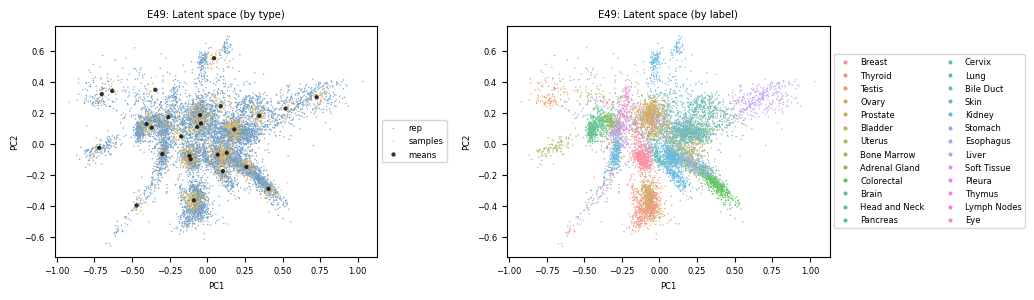

100 6.459213316362224 6.493524214935712


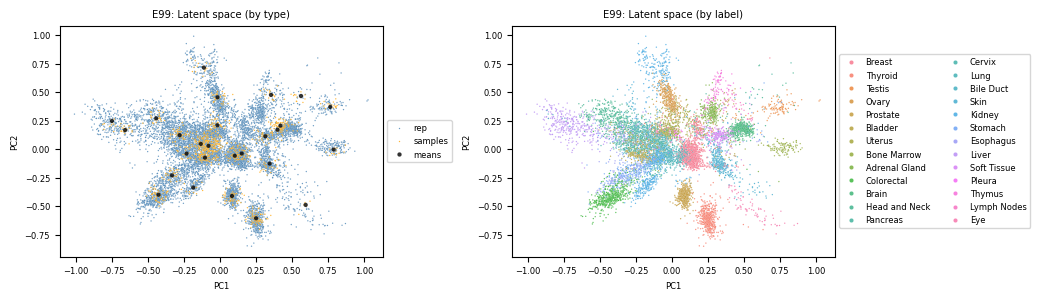

150 6.3480836348910685 6.3853025680152005


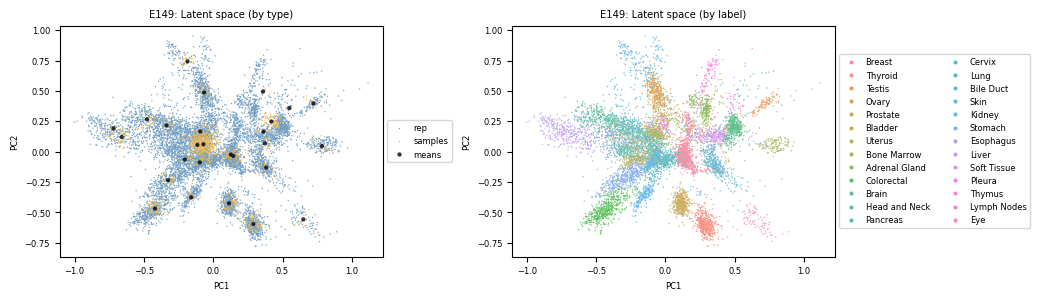

200 6.302530367603952 6.342643179642288


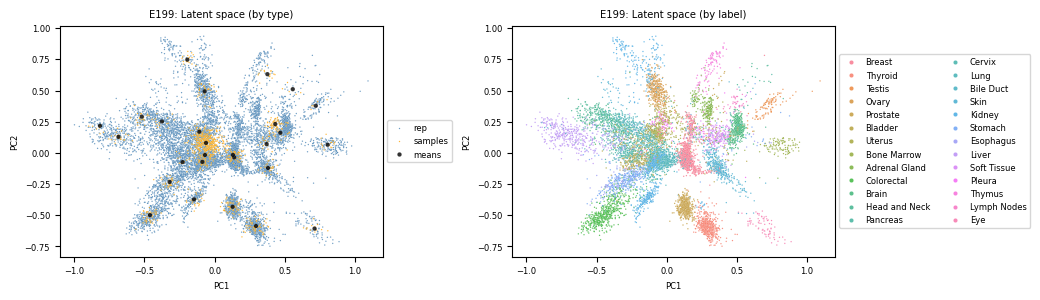

250 6.278937648837761 6.321699353012535


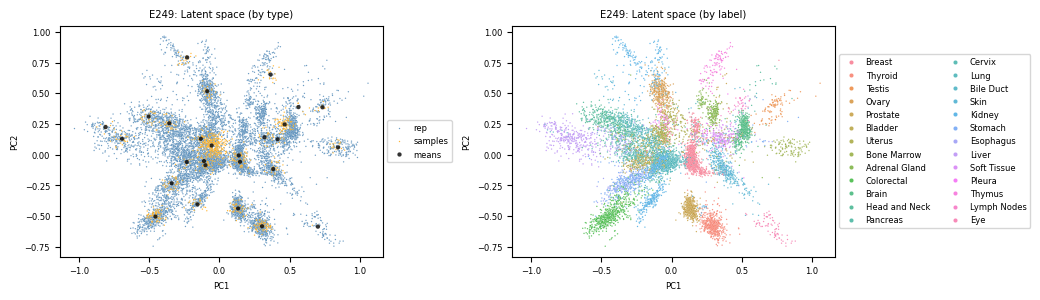

300 6.2648838602228105 6.308881571108287


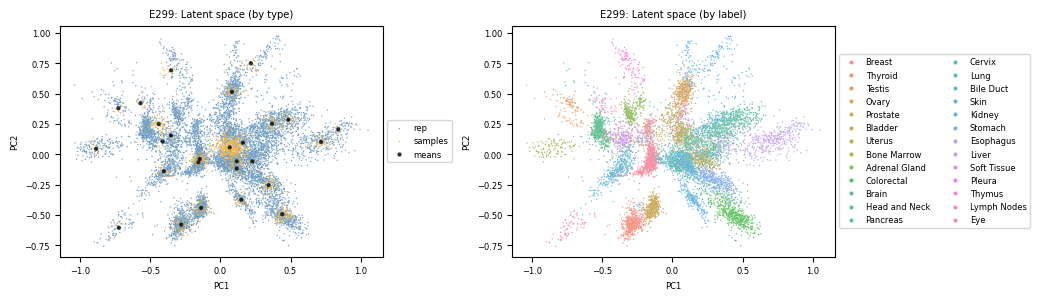

In [18]:
# train for 10 epochs and plot learning curves
n_epochs = 300
pr = 50 # how often to print
plot = 50

loss_tab = train_dgd(
    dgd, train_loader, test_loader, device, 
    learning_rates={'dec':0.001,'rep':0.01,'gmm':0.01},
    weight_decay=0.,nepochs=n_epochs,pr=pr,plot=plot,reduction_type=reduction_type
    )
# stuff is running but I have to check the loss normalization for printing and plotting, they seem a bit large

# Plotting

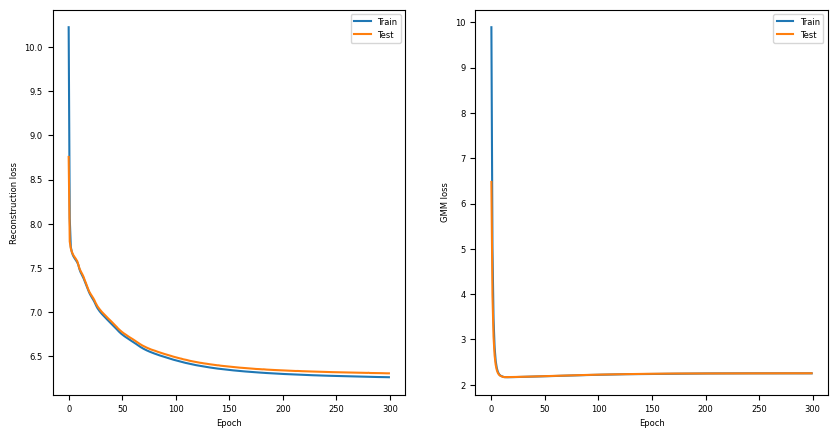

In [19]:
import matplotlib.pyplot as plt
# make 2 subplots with recon and gmm loss curves

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(loss_tab["Epoch"],loss_tab["Train recon"],label="Train")
plt.plot(loss_tab["Epoch"],loss_tab["Test recon"],label="Test")
plt.xlabel("Epoch")
plt.ylabel("Reconstruction loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(loss_tab["Epoch"],loss_tab["GMM train"],label="Train")
plt.plot(loss_tab["Epoch"],loss_tab["GMM test"],label="Test")
plt.xlabel("Epoch")
plt.ylabel("GMM loss")
plt.legend()
plt.show()

In [20]:
dgd

DGD(
  (decoder): Decoder(
    (main): ModuleList(
      (0): Linear(in_features=20, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=128, bias=True)
      (5): ReLU()
    )
    (out_modules): ModuleList(
      (0): NB_Module(
        (fc): Sequential(
          (0): Linear(in_features=128, out_features=19784, bias=True)
        )
      )
    )
  )
  (gmm): GaussianMixture()
  (train_rep): RepresentationLayer()
  (val_rep): RepresentationLayer()
)

In [21]:
torch.save(dgd.state_dict(), "saved_model/09032024_tcga_first.pth")